## LOW FREQUENCY SAMPLING IN MODEL PREDICTIVE PATH INTEGRAL CONTROL
## Final Project EECE 5550 
#### adapted from original work by Michael Everett
#### jasen levoy cw 2025
### This alternative approach to my roll-your-own version uses the library map functions and a custom maze.py env script 

In [1]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models

In [2]:
env = gymnasium.make("gym_neu_racing/Maze-v0")

env = StateFeedbackWrapper(env)

min(scores): 172.3081593553847
max(weights): 0.24303733870731886
min(scores): 169.8902220227707
max(weights): 0.10451444893807395
min(scores): 168.2035064612599
max(weights): 0.06968844323535303
min(scores): 166.14866883906643
max(weights): 0.08424946367391935
min(scores): 165.6035008438586
max(weights): 0.034177281649667525
min(scores): 163.40647275766398
max(weights): 0.04413150748866922
min(scores): 161.35717096677956
max(weights): 0.07725649756779025
min(scores): 160.58033564403175
max(weights): 0.04236512781148541
min(scores): 158.80208708560582
max(weights): 0.05584531543052888
min(scores): 157.2250102414125
max(weights): 0.10585762040749444
min(scores): 155.84521147495957
max(weights): 0.06084512499183204
min(scores): 154.4381212055944
max(weights): 0.07137498598208845
min(scores): 153.48648149419336
max(weights): 0.05297990529852825
min(scores): 151.4277434209668
max(weights): 0.11279117627780225
min(scores): 150.04896333150157
max(weights): 0.09321832725883725
min(scores): 148

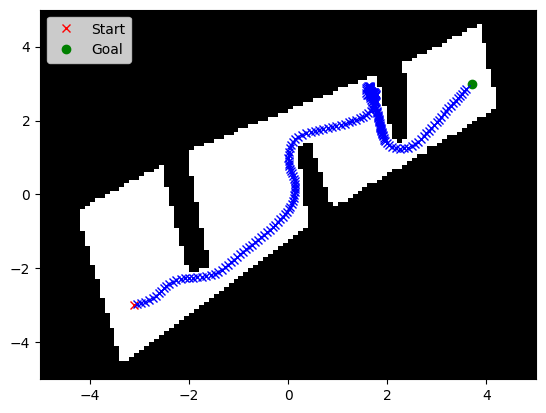

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_neu_racing.motion_models as motion_models

def generate_colored_noise(num_rollouts, horizon, dt, noise_std, gamma):
    """
    generate colored noise with exponent gamma to control spectral
    power attenuation by freq
    
    parameters:
      num_rollouts: num rollout sequences
      horizon: num timesteps
      dt: timestep duration
      noise_std: standard dev in time domain
      gamma: exponent for frequency scaling (higher=smoother)
      
    returns:
      noise_time: np.ndarray of shape (num_rollouts, horizon)
    """
    # compute frequency bins
    freqs = np.fft.rfftfreq(horizon, d=dt)
    scaling = np.where(freqs == 0, 0, 1.0 / (freqs ** gamma))
    # generate random complex noise in freq domain
    noise_freq = (np.random.normal(0, 1, (num_rollouts, len(freqs))) +
                  1j * np.random.normal(0, 1, (num_rollouts, len(freqs))))
    noise_freq = noise_freq * scaling[np.newaxis, :] #apply freq scaling
    
    # inverse FFT for time-domain noise, then irfft for real-valued sig
    noise_time = np.fft.irfft(noise_freq, n=horizon, axis=1)
    current_std = np.std(noise_time, axis=1, keepdims=True) # normalize noise to get std
    noise_time = noise_time / (current_std + 1e-8) * noise_std
    
    return noise_time

def generate_smooth_mppi_noise(num_rollouts, horizon, dt, noise_std):
    """
    smooth-MPPI noise. sample in derivative space, then integrate
    
    noise_std here is desired std dev of final * Δu
    paper suggest scaling derivative std by 1/dt:
      sigma_delta = noise_std / dt
    """
    #sampling derivative noise
    sigma_delta = noise_std / dt
    d_noise = np.random.normal(
        loc=0.0,
        scale=sigma_delta,
        size=(num_rollouts, horizon)
    )
    #integrate to get smooth noise over horizon
    noise_time = np.cumsum(d_noise, axis=1) * dt
    
    return noise_time

def sample_log_mppi_noise(num_rollouts, horizon, mu, sigma):
    #draw a normal scale, then log‑normal perturbation
    scales = np.random.lognormal(mean=mu, sigma=sigma, size=(num_rollouts, horizon))
    return np.random.normal(0, 1, (num_rollouts, horizon)) * scales

class MPPIMaze:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        no_of_rollouts= 250,
        v_limits=[0, 1],
        w_limits=[-2 * np.pi, 2 * np.pi],
        lam=.9, #.5
        t=10,
        dt: float = 0.1,
        # lambda_: float = 0.8,
        # alpha: float = 0.7,
        noise_std_angular: float = 1.5,  # radians
        noise_std_linear: float = 0.0002,
        gamma_linear: float = 2,    # exponent for linear control noise
        gamma_angular: float = 2,    # exponent for angular control noise
        sigma: float = 1.5, # paper uses 0.5, 1.5, 3.0 for each method
        mu: float = 0.0 # for log-MPPI
        
    ):
        """
        MPPI controller for maze env with a goal and several waypoints
        - static_map: The maze's occupancy grid (from env.unwrapped.map)
        - motion_model: unicylce motion model
        - no_of_rollouts: number of rollouts
        - v_limits, w_limits: action bounds for linear and angular velocity
        - lam: temp param for MPPI weights
        - t: horizon length in timesteps for each rollout
        """
        self.motion_model = motion_model
        self.static_map = static_map
        self.no_of_rollouts = no_of_rollouts
        self.v_limits = v_limits
        self.w_limits = w_limits
        self.lam = lam
        self.t = t
        self.dt = dt
        self.last_control = np.array([0.5, -0.5])

        # self.lambda_ = lambda_
        # self.alpha = alpha
        self.noise_std_linear = noise_std_linear
        self.noise_std_angular = noise_std_angular
        self.gamma_linear = gamma_linear
        self.gamma_angular = gamma_angular
        self.mu = mu
        self.sigma = sigma

    def control_disturbance_matrix(self):
        """
        Log-MPPI version.
        disturbances generated separately for linear and angular control.
        Additionally, im injecting a small, opposite directional bias into half of rollouts
        to help avoid getting stuck going straight into a wall, it seems to help
        
        returns:
        disturbances: np.ndarray of shape (self.no_of_rollouts, self.t, 2),
                        where last dim holds [v disturbance, ω disturbance]
        """
        # generate log gaussian noise for linear channel
        noise_linear = sample_log_mppi_noise(
            self.no_of_rollouts, 
            self.t, #horizon 
            self.mu, 
            self.sigma)
        
        # generate log gaussian noise for the angular channel
        noise_angular = sample_log_mppi_noise(
            self.no_of_rollouts, 
            self.t, #horizon 
            self.mu, 
            self.sigma)
        
        #force half rollouts to turn slightly one way, other half other way
        # 0.1 rad is about 6 degrees
        angular_bias = 0.05
        bias = np.zeros_like(noise_angular)
        half = self.no_of_rollouts // 2
        bias[:half, :] = angular_bias   # first half pos bias
        bias[half:, :] = -angular_bias  # second half neg bias
        
        # add bias to generated angular noise
        noise_angular += bias
        
        # combine linear and angular noise into a single disturbance matrix
        disturbances = np.stack([noise_linear, noise_angular], axis=-1)
        return disturbances


    def score_rollouts(self, control_sequences, initial_state, goal_pos):
        """
        compute cost of each rollout
        - accumulate distance-to-goal cost
        - accumulate cost based on proximity to obstacles
        - impose large penalty if collision occurs
        
        encourages rollouts to find paths around obstacles, even
        if that initially moves it away from a direct line to the goal
        """
        scores = []
        for seq_idx, control_sequence in enumerate(control_sequences):
            total_cost = 0
            state = initial_state.copy()
            collision_occurred = False

            for control in control_sequence:
                # Step robot forward (using the controller's dt)
                state = self.motion_model.step(state, control, dt=self.dt)
                # compute Euclidean distance from the current state to goal
                dist_to_goal = np.linalg.norm(state[:2] - goal_pos)

                # Determine map indices and check for collision.
                map_indices, in_map = self.static_map.world_coordinates_to_map_indices(state[:2])
                if (not in_map) or self.static_map.static_map[map_indices[0], map_indices[1]]:
                    collision_occurred = True
                    break

                # compute an obstacle proximity cost from current state
                obs_cost = self.compute_obstacle_cost(state[:2])

                # combine costs: weight distance cost and obstacle cost
                total_cost += 2 * dist_to_goal + obs_cost

            # if a collision occurred, add large penalty
            if collision_occurred:
                total_cost = 1e3

            scores.append(total_cost)

        return scores


    def compute_obstacle_cost(self, pos):
        """
        repulsive obstacle cost increases as pos approaches occupied cells
        
        params:
            pos: np.array, the (x, y) position in world coords
            
        returns:
            cost: A scalar cost value representing repulsive cost due to obstacles
        """
        # convert world coordinate to map indices
        map_indices, in_map = self.static_map.world_coordinates_to_map_indices(pos)
        # if pos out of bounds, return a high cost
        if not in_map:
            return 1e3

        cost = 0.0
        # get shape of occupancy grid
        nrows, ncols = self.static_map.static_map.shape

        # define a neighborhood to inspect, using a 3x3 neighborhood
        for i in range(max(0, map_indices[0] - 1), min(nrows, map_indices[0] + 2)):
            for j in range(max(0, map_indices[1] - 1), min(ncols, map_indices[1] + 2)):
                if self.static_map.static_map[i, j]:
                    # get world coords at center of cell (i, j)
                    center_x, center_y = self.static_map.map_indices_to_world_coordinates((i, j))
                    # compute Euclidean distance from pos to cell center
                    d = np.linalg.norm(pos - np.array([center_x, center_y]))
                    # add a cost inversely related to distance with an epsilon for numerical stability
                    epsilon = 1e-3
                    cost += 10.0 / (d + epsilon)  # scaling factor
        return cost


    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray): #[[-1.2,-2],[0.5,1.7],[2.4,1.2]]
        """
        compute optimal action to move towards goal
        returns a single action (v, w) for current timestep
        """
        # if len(waypoints)<3:
        #     waypoints.append(goal_pos)
        # current_goal = waypoints[0]
        current_goal = goal_pos
        # nominal control seq repeated t times
        nominal_sequence = np.array([self.last_control for _ in range(self.t)])

        # create random perturbations, add to nominal sequence
        disturbances = self.control_disturbance_matrix()
        control_sequences = nominal_sequence + disturbances
        control_sequences[:, :, 0] = np.clip( #clip
            control_sequences[:, :, 0], self.v_limits[0], self.v_limits[1]
        )  # linear velocity
        control_sequences[:, :, 1] = np.clip(
            control_sequences[:, :, 1], self.w_limits[0], self.w_limits[1]
        )  # angular velocity
        # print(waypoints)
        # Compute costs for all rollouts
        scores = self.score_rollouts(control_sequences, initial_state, current_goal)

        # MPPI weighting
        scores = np.array(scores)
        print(f"min(scores): {min(scores)}")
        weights = np.exp(-scores / self.lam)
        weights /= np.sum(weights)
        # print("Weights:", weights)  
        print(f"max(weights): {max(weights)}")
        # weighted sum of the control increments
        delta_u = control_sequences - nominal_sequence
        merged_sequence = nominal_sequence + np.sum(
            (weights[:, None, None] * delta_u), axis=0
        )

        #first control of merged sequence is final action
        self.last_control = merged_sequence[0]
        # if np.linalg.norm(initial_state[0:2] - current_goal) < 0.3:
        #     waypoints.pop(0) #lose last waypoint if within thresh
        return merged_sequence[0]


def run_planner_on_maze(
    env: gym.Env,
    planner_class=MPPIMaze,
    seed: int = 26,
    max_steps: int = 300
) -> int:
    """
    run MPPI planner in maze environment until either:
      > agent reaches the goal (env terminates)
      > agent collides with a wall (env terminates)
      > maximum number of steps exceeded

    returns number of timesteps used, or -1 if goal not reached
    """
    np.random.seed(seed)
    obs, _ = env.reset(seed=seed)
    goal_pos = env.unwrapped.goal_pos
    planner = planner_class(static_map=env.unwrapped.map) #create instance of planner
    # waypoints = np.array([[-1.2,-2],[2.4,1.2]])
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(obs[0], obs[1], "rx", label="Start") # plot start and goal
    ax.plot(goal_pos[0], goal_pos[1], "go", label="Goal")
    # ax.plot(waypoints[:,0],waypoints[:,1], "o", label = "Waypoints")
    ax.legend(loc="upper left")
    # print("Initial position:", obs)
    success = False # step env
    for t in range(max_steps):
        action = planner.get_action(obs, goal_pos)
        obs, reward, terminated, truncated, info = env.step(action)
        ax.plot(obs[0], obs[1], "bx") # plot path
        # if t % 50 == 0:
        #     ax.text(obs[0], obs[1], str(t), fontsize=10, color="orange")
        if terminated or truncated:
            # MazeEnv sets terminated=T when goal reached
            success = (reward > 0)
            break
    plt.show()

    if success:
        return t
    else:
        return -1

if __name__ == "__main__":
    num_timesteps_used = run_planner_on_maze(env, planner_class=MPPIMaze, seed=26)
    # print(f"Number of timesteps used: {num_timesteps_used}")